In [69]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import optuna
import os
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from datetime import datetime

now = datetime.now()
NOW_STR = f'{now.year}_{now.month}_{now.day}'

# Definir estilo do seaborn
sns.set_theme(style="whitegrid")


SEED = 42 # Muito importante manter a SEED igual em todos os modelos para garantir a consistência dos dados no ensemble
FOLDS = 5 # Muito importante manter o mesmo número de FOLDS em todos os modelos para garantir a consistência dos dados no ensemble

PATH = 'models/' # Caminho para os modelos
CLASSES = ["Enrolled","Graduate", "Dropout"]

scores = {} # Dicionário para armazenar os scores de estratégia de ensemble

# Listar todos os diretórios na pasta especificada
directories = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
individual_models = directories.copy()
print(directories)

['lgbm_1', 'xgb_1', 'lgbm_2', 'faml_1', 'cat_1']


In [48]:
sub = pd.read_csv('src/test/sample_submission.csv', index_col='id')

In [34]:
import numpy as np
import pandas as pd

class SoftVotingClassifier:
    def __init__(self, classifiers, classes):

        self.classifiers = classifiers
        self.classes = classes
        self.nclasses = len(classes)

    def fit(self, X, y):
        pass
    
    def predict(self, df):

        prob_sum = np.zeros((len(df), self.nclasses))

        self.classes_cols = []
        for i, classe in enumerate(self.classes):
            self.classes_cols.append([col for col in df.columns if col.endswith(classe)])
            prob_sum[:,i] = df[self.classes_cols[i]].sum(axis=1)

        # Normaliza as probabilidades somadas
        prob_sum /= len(self.classifiers)
        
        # Predição final é a classe com a maior probabilidade
        # predictions = self.classes[np.argmax(prob_sum, axis=1)]
        predictions = np.argmax(prob_sum, axis=1)
        
        return predictions


In [35]:
def build_dfs(directories):

    folds = []

    for i in range(FOLDS):

        models_predictions = []

        for model in directories:
            # Carregar o modelo
            df = pd.read_csv(f'{PATH}{model}/oof/fold_{i+1}.csv')
            columns = df.columns
            df.columns = [f'{model}_{col}' for col in columns]
            df.rename(columns={f'{model}_true': 'true_label'}, inplace=True)
            models_predictions.append(df)

        # Concatenar as previsões de todos os modelos
        df = pd.concat(models_predictions, axis=1)
        df = df.loc[:, ~df.columns.duplicated(keep='last')] # Remover colunas duplicadas(true label)
        folds.append(df)


    return folds

In [61]:
def build_test_set(directories):

    models_predictions = []

    for model in directories:
        # Carregar o modelo
        df = pd.read_csv(f'{PATH}{model}/test/test_pred.csv')
        columns = df.columns
        df.columns = [f'{model}_{col}' for col in columns]
        models_predictions.append(df)

    # Concatenar as previsões de todos os modelos
    df = pd.concat(models_predictions, axis=1)

    return df

In [36]:
def cross_validation(model, folds, target_column='true_label', scoring=accuracy_score, verbose=1):
    scores = []
    
    for i, fold in enumerate(folds):

        if verbose == 1:
            print(f"Fold {i + 1}")
        
        # Separando o conjunto de treino e validação
        train_folds = folds[:i] + folds[i+1:]
        val_fold = fold
        
        # Concatenando os DataFrames de treino
        train_df = pd.concat(train_folds, ignore_index=True)
        
        # Separando as features e o target
        X_train = train_df.drop(columns=[target_column])
        y_train = train_df[target_column]
        
        X_val = val_fold.drop(columns=[target_column])
        y_val = val_fold[target_column]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões no conjunto de validação
        y_pred = model.predict(X_val)
        
        # Calculando a métrica de avaliação
        score = scoring(y_val, y_pred)
        scores.append(score)
                
    if verbose == 1:
        print(f"Score: {np.mean(scores)}")
    
    return scores

In [37]:
def summarize_models(scores, models, folds, encoder, scoring=accuracy_score):

    models_scores = {}
    
    for model in models:
        model_scores = []

        for fold in folds:
            model_cols = [col for col in fold.columns if col.startswith(model)]
            y_true = fold['true_label'].map(encoder)
            y_pred = fold[model_cols].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

            score = scoring(y_true, y_pred)
            model_scores.append(score)
        
        models_scores[model] = model_scores

    scores.update(models_scores)
    
    means = {key: np.mean(value) for key, value in scores.items()}

    # Preparar dados para o gráfico
    keys = list(means.keys())
    values = list(means.values())

    # Criar DataFrame e ordenar pelos valores de forma decrescente
    data = pd.DataFrame({'Keys': keys, 'Mean Values': values})
    data = data.sort_values(by='Mean Values', ascending=False)

    # Plotar gráfico de barras horizontal
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x='Mean Values', y='Keys', data=data, palette='viridis')

    # Adicionar valores ao lado de cada barra
    for index, value in enumerate(data['Mean Values']):
        ax.text(value, index, f'{value:.4f}', color='black', va="center")

    plt.xlim(min(values) * 0.995, max(values) * 1.001)  # Ajustar a escala do eixo x para ser 10% maior que o valor máximo

    plt.xlabel('Score')
    plt.ylabel('Model')
    plt.title('Accuracy Score of Models')

    plt.show()

In [71]:
def predict_test(name, model, folds, X_test, encoder, sample_sub):

    train = pd.concat(folds, ignore_index=True)

    y_train = train.pop('true_label')
    X_train = train

    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    map_func = np.vectorize(lambda x: encoder[x])
    pred_mapped = map_func(pred)

    sample_sub['Target'] = pred_mapped

    os.makedirs('submission', exist_ok=True)

    sample_sub.to_csv(f'submission/{name}-{NOW_STR}.csv')

    return sample_sub

In [38]:
folds = build_dfs(directories)
test = build_test_set(directories)

In [39]:
for fold in folds:
    fold['true_label'] = fold['true_label'].replace({"Enrolled": 0, "Graduate": 1, "Dropout": 2})

encoder = {0: "Enrolled", 1: "Graduate", 2: "Dropout"}

In [40]:
logreg_best_params = {'penalty': 'none', 'C': 0.0008211450746102205, 'solver': 'sag', 'multi_class': 'multinomial'}

logreg = LogisticRegression(**logreg_best_params)

scores['logreg_ensemble'] = cross_validation(logreg, folds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8334362556594763


In [41]:
xgb = XGBClassifier(random_state=42)

scores['xgb_ensemble']  = cross_validation(xgb, folds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8307800540511062


In [42]:
svc = SoftVotingClassifier(directories, CLASSES)

scores['svc_ensemble']  = cross_validation(svc, folds, scoring=accuracy_score)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8328308910849742


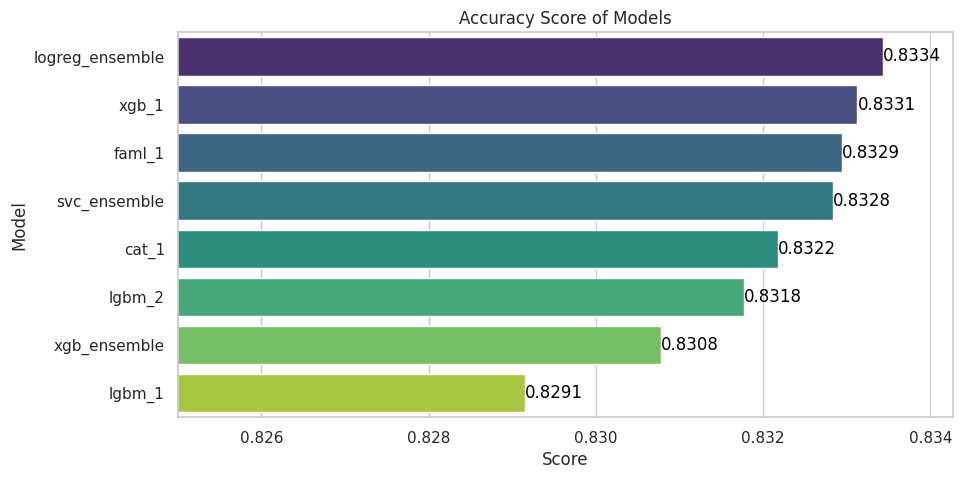

In [43]:
summarize_models(scores, individual_models, folds, encoder)

In [44]:
# Definir a função objetivo
def objective(trial):
    # Hiperparâmetros do LogisticRegression a serem otimizados
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    C = trial.suggest_loguniform('C', 1e-5, 10)
    solver = trial.suggest_categorical('solver', ['sag', 'saga', 'lbfgs', 'newton-cg'])
    multi_class = trial.suggest_categorical('multi_class', ['auto', 'multinomial'])
    
    # Definir o modelo
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, multi_class=multi_class, max_iter=10000, random_state=42)
    
    score = np.mean(cross_validation(model, folds, verbose=0))
    
    return score

warnings.filterwarnings("ignore")

# Criar um estudo com um callback para early stopping
study = optuna.create_study(direction='maximize')

# Realizar a otimização
study.optimize(objective, n_trials=50)

[I 2024-06-17 22:57:45,053] A new study created in memory with name: no-name-67fcf6a5-09a7-4928-b6b6-8cd481aad09a
[I 2024-06-17 22:57:45,712] Trial 0 finished with value: 0.8321761178717859 and parameters: {'penalty': 'l2', 'C': 0.00021567735421627329, 'solver': 'lbfgs', 'multi_class': 'multinomial'}. Best is trial 0 with value: 0.8321761178717859.
[I 2024-06-17 22:57:50,684] Trial 1 finished with value: 0.8334362556594763 and parameters: {'penalty': 'none', 'C': 3.7172968987312305, 'solver': 'newton-cg', 'multi_class': 'auto'}. Best is trial 1 with value: 0.8334362556594763.
[W 2024-06-17 22:57:55,567] Trial 2 failed with parameters: {'penalty': 'none', 'C': 0.0859059763362904, 'solver': 'sag', 'multi_class': 'auto'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rafael/anaconda3/envs/penidoEnv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_4

KeyboardInterrupt: 

In [ ]:
# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia: ", study.best_value)

Melhores hiperparâmetros:  {'penalty': 'none', 'C': 0.0008211450746102205, 'solver': 'sag', 'multi_class': 'multinomial'}
Melhor acurácia:  0.8334362556594763


In [72]:
predict_test('logreg', logreg, folds, test, encoder, sub)

,Target
id,
76518,Dropout
76519,Graduate
76520,Graduate
76521,Enrolled
76522,Enrolled
...,...
127525,Dropout
127526,Dropout
127527,Dropout
